# Timeseries_02-CreateModel

This is intended to load data prepared with the script `Timeseries_01-CompileInputData.R` and create a time series model predicting groundwater levels using the [`pastas`](https://pastas.readthedocs.io/en/latest/index.html) package.

It closely follows the [example on the `pastas` website](https://pastas.readthedocs.io/en/latest/examples/001_basic_model.ipynb.html).

## Running to-do list:
 - Check offset between stage data and water level data
     - also compare between nested well sets: LWPH4, LEC, LEA
 - Extend input dataset to 1994 (10 years before first groundwater level data)

## Set up workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## Load and check input data
We have data from three nested wells:
 - `LWPH4a` = shallow alluvial aquifer
 - `LWPH4b` = deep alluvial aquifer
 - `LWPH4c` = High Plains aquifer, separated from the alluvial aquifer by a (leaky?) confining layer.
We also have data about the river stage (`stage_masl`). This is `NaN` whenever flow in the river ceases.

The data type of the series is: <class 'pandas.core.frame.DataFrame'>
Variables are:  ['prcp_mm', 'tmax_c', 'tmin_c', 'ETo_mm', 'discharge_cms', 'stage_masl', 'LWPH4a', 'LWPH4b', 'LWPH4c']


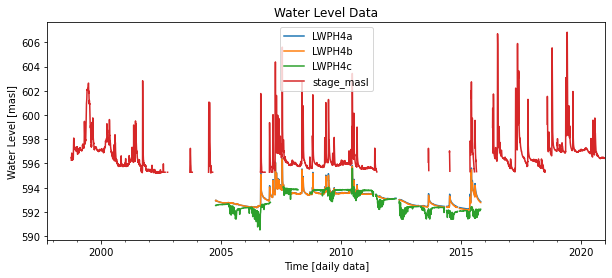

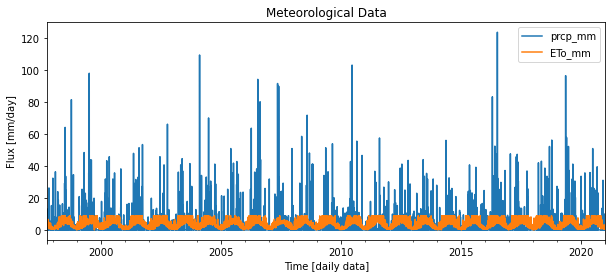

In [2]:
# Import input data time series and squeeze to Series object
inputdata = pd.read_csv('../data/Timeseries_InputData.csv', parse_dates=['date_ghcn'],
                        index_col='date_ghcn', squeeze=True)
print('The data type of the series is: %s' % type(inputdata))

# show names of columns
print('Variables are: ', list(inputdata))

# separate into water level data and meteorological data
hydrodata = inputdata[["LWPH4a", "LWPH4b", "LWPH4c", "stage_masl"]]
hydrodata.plot(figsize=(10, 4))
plt.title('Water Level Data');
plt.ylabel('Water Level [masl]');
plt.xlabel('Time [daily data]');

metdata = inputdata[["prcp_mm", "ETo_mm"]]
metdata.plot(figsize=(10, 4))
plt.title('Meteorological Data');
plt.ylabel('Flux [mm/day]');
plt.xlabel('Time [daily data]');


## Build simple model

In [3]:
# calculate daily precipitation surplus (P-ETo)
precSurplus_mm = metdata["prcp_mm"] - metdata["ETo_mm"]

# Create a model object by passing it the observed series
ml_lwph4a = ps.Model(hydrodata["LWPH4a"], name="GWL")

# Add the recharge data as explanatory variable
sm_precSurplus = ps.StressModel(precSurplus_mm, ps.Gamma, name='PrecSurplus', settings="evap")
ml_lwph4a.add_stressmodel(sm_precSurplus)

INFO: Nan-values were removed at the start of the time series LWPH4a.
INFO: Nan-values were removed at the end of the time series LWPH4a.
INFO: Inferred frequency for time series LWPH4a: freq=D
INFO: Time Series LWPH4a: 227 nan-value(s) was/were found and filled with: drop.
INFO: Inferred frequency for time series None: freq=D


## Solve model and plot results

INFO: Time Series None was extended to 1994-10-09 00:00:00 with the mean value of the time series.


Fit report GWL                     Fit Statistics
nfev     14                     EVP             1.51
nobs     3807                   R2              0.01
noise    True                   RMSE            0.58
tmin     2004-10-06 00:00:00    AIC            -4.31
tmax     2015-10-22 00:00:00    BIC            26.91
freq     D                      Obj            14.89
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           Interpolated      No

Parameters (5 were optimized)
                  optimal   stderr     initial  vary
PrecSurplus_A    0.053525  ±11.79%    0.133962  True
PrecSurplus_n    2.568124   ±6.50%    1.000000  True
PrecSurplus_a    3.332517  ±12.25%   10.000000  True
constant_d     593.219002   ±0.02%  593.137841  True
noise_alpha     83.364841  ±20.46%    1.000000  True

Parameter correlations |rho| > 0.5
PrecSurplus_A PrecSurplus_n -0.61
              PrecSurplus_a  0.79
PrecSurplus_n PrecSurplus_a -0.91


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'left':'Model Parameters'}>,
 <AxesSubplot:title={'right':'Stresses: [None]'}>,
 <AxesSubplot:xlabel='Time [days]'>]

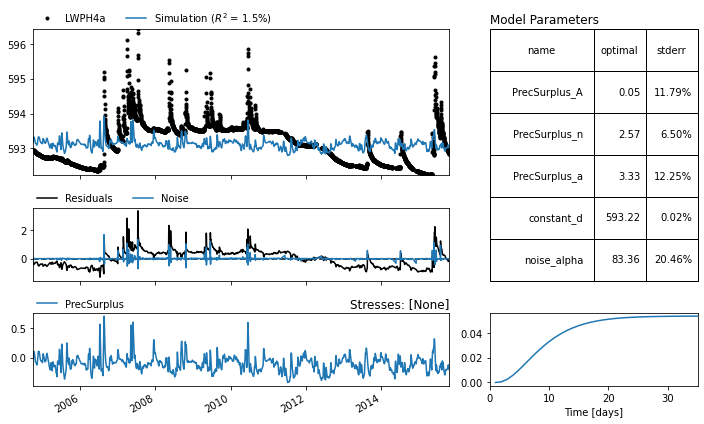

In [4]:
# solve
ml_lwph4a.solve()

# plot
ml_lwph4a.plots.results(figsize=(10, 6))